In [1]:
from src.setup import *
from src import host
from src import common
# This prevents to restart the kernel whenever an external file is edited
%load_ext autoreload
%autoreload 2

# Introduction

In this notebook, we'll do a complete GWAS **from strach**, i.e. beginning with the raw, dirty data, and focus on asian individuals. The principle is to re-run all quality control steps to get a **new dataset** that is not biased by individuals that won't be included in the study. For instance, MAF filtering can be biased when subpopulations with different allele frequencies are present. We also want to avoid such biases with missing values and chromosomes, for example. 

The path to the clean dataset for this study is defined by `PATH_ASIANS_GWAS`.

###### Selection of individuals

The clustering that was done in the previous notebook did not provide any satisfying result. Thus we will use a list of individuals that belong to a same cluster, according to the same clustering algorithm (hierarchichal, ward) but done with R (thanks to Sina for providing me the list). This list is specified by `PATH_CLUSTERING_ASIANS`.

###### Plan

1. Prepare dataset for QC: Exclude variants with 100% missing rate, remove relevant chromosomes, keep only relevant individuals, create **new (dirty) dataset**.
1. Quality control
    1. Missing values (variants), create intermediate dataset
    1. Missing values (individuals)
    1. MAF filtering, HWE tests
1. Association analyses

We want to force the order of missingness filtering (first variants, then individuals, i.e. unlike plink does when both commands are run at the same time), thus we create an intermediate dataset after the filtering of missing variants.

# Preparation

At the end of this section, we create a new dataset that is ready for **unbiased** quality control. The filters here are :

* Remove variants with 100% missingness
* Keep only autosomes
* Keep only asian related individuals (a cluster)

In [4]:
# Define the path for this new dataset
path_prepared_dataset = PATH_PLINK_DATA+"asians_gwas_prepared"

In [9]:
# 1. Remove variants with 100% missing rate
host.run_plink("--geno 0.999999999 " + DEFAULT_CHROMOSOME_EXCLUSION_GWAS + \
               " --keep " + PATH_CLUSTERING_ASIANS + " --make-bed",
               file=PATH_HOST_RAW_PLINK_DATA, out=path_prepared_dataset, extension='bed',
               log_name='asians_gwas_0_data_preparation');

Running 'plink2 --bfile data/raw/wes_plink/hbv_gilead_bcftools --out data/plink/asians_gwas_prepared --geno 0.999999999 --not-chr 0 X Y XY MT --keep data/clustering_asians_gwas.txt --make-bed '
Log written to 'data/plink/log/asians_gwas_data_preparation.log'


# Quality control

We start the QC with he dataset defined by `path_prepared_dataset`.

###### Missing report



Running 'plink2 --bfile data/plink/asians_gwas_prepared --out data/plink/asians_gwas_prepared --missing '
Log written to 'data/plink/log/asians_gwas_missing.log'


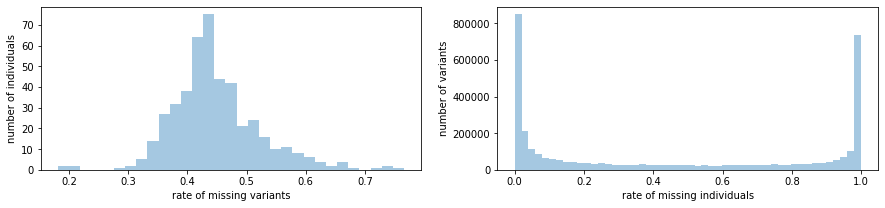

In [14]:
host.run_plink("--missing", file=path_prepared_dataset, out=path_prepared_dataset, 
               extension='vmiss', log_name='asians_gwas_1_missing')
common.plot_missing(path_prepared_dataset)

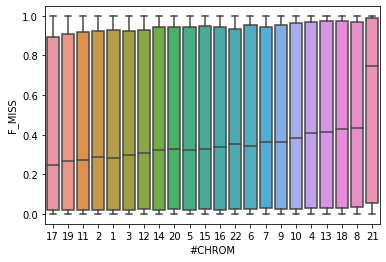

In [19]:
dtype = {'F_MISS':float, 'ID':str, '#CHROM':str}
df_miss_var = pd.read_csv(path_prepared_dataset+'.vmiss', sep='\s+', usecols=['#CHROM', 'ID', 'F_MISS'], dtype=dtype)
df_miss_chr = df_miss_var.groupby('#CHROM').mean()
sns.boxplot(x='#CHROM', y='F_MISS', data=df_miss_var, order=df_miss_chr.sort_values(by='F_MISS').index);

###### Filter variants

In [20]:
# 1. Path for this intermediate dataset
path_intermed_dataset = PATH_PLINK_DATA+"asians_gwas_intermed_QC"

In [21]:
# 2. Filter
host.run_plink("--geno " + str(THRESHOLD_MISSING_VARIANTS) + " --make-bed", file=path_prepared_dataset,
              out=path_intermed_dataset, extension='bed', log_name='asians_gwas_2_intermedQC');

Running 'plink2 --bfile data/plink/asians_gwas_prepared --out data/plink/asians_gwas_QC_intermed --geno 0.01 --make-bed '
Log written to 'data/plink/log/asians_gwas_intermedQC.log'


###### Filter individuals

In [23]:
path_missingness_treated_dataset = PATH_PLINK_DATA+"asians_gwas_missingness_treated"

In [25]:
host.run_plink("--mind " + str(THRESHOLD_MISSING_INDIVIDUALS) + " --make-bed", file=path_intermed_dataset,
              out=path_missingness_treated_dataset, extension='bed', log_name='asians_gwas_3_miss_treated');

Running 'plink2 --bfile data/plink/asians_gwas_QC_intermed --out data/plink/asians_gwas_missingness_treated --mind 0.1 --make-bed '
Log written to 'data/plink/log/asians_gwas_miss_treated.log'


###### Missing report of missingness treated dataset

Running 'plink2 --bfile data/plink/asians_gwas_missingness_treated --out data/plink/asians_gwas_missingness_treated --missing '
Log written to 'data/plink/log/asians_gwas_missing.log'


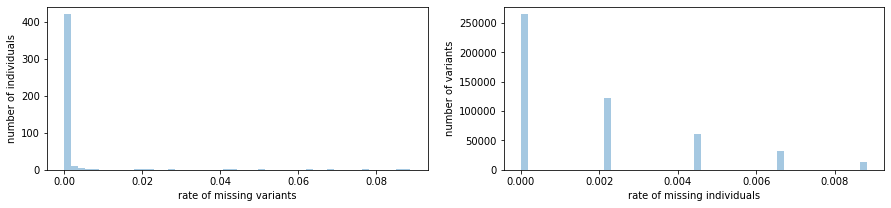

In [27]:
host.run_plink("--missing", file=path_missingness_treated_dataset, out=path_missingness_treated_dataset, 
               extension='vmiss', log_name='asians_gwas_4_missing')
common.plot_missing(path_missingness_treated_dataset)

###### MAF and HWE

In [29]:
host.run_plink("--maf 0.01 --hwe 1e-6 --make-bed", file=path_missingness_treated_dataset, extension='bed',
              out=PATH_ASIANS_GWAS, log_name='asians_gwas_5_maf_hwe');

Running 'plink2 --bfile data/plink/asians_gwas_missingness_treated --out data/plink/asians_gwas --maf 0.01 --hwe 1e-6 --make-bed '
Log written to 'data/plink/log/asians_gwas_maf_hwe.log'


# Association analyses



# Multivariate model

From [plink doc](https://www.cog-genomics.org/plink/1.9/input#covar):

> `--covar` designates the file to load covariates from. The file format is the same as for --pheno. The main phenotype is no longer set to missing when a covariate value is missing; instead, this only happens to the temporary phenotype copies used by e.g. the linear/logistic regression routine.
>
>Categorical covariates are now directly supported. Any nonnumeric string ('NA' and 'nan' are considered to be numbers for this purpose) is treated as a categorical covariate name.
>
>`--covar-name` works like --pheno-name. It can now be used without --covar (in which case the --pheno or .psam file is the target).
>
>`--covar-col-nums` works like --pheno-col-nums, and refers to the --pheno file when --covar is not specified.
>
>When no primary header line is present, covariates are assigned the names 'COVAR1', 'COVAR2', etc.

Thus we need a to manage the writing of new files containing covariate information. <s>We can create a function that calls `write_phenotype` since the format is the same (two columns with FID, IID and one variable per column, we also need to keep the intersection of the individuals, the variables to include are contained in the clinical dataframe).</s> We can  actually use the same `write_phenotype` function that we tune for that purpose